# Model

## Load the model with pretrained weights

In [1]:
import torch
from torchvision.models import vgg16

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
weight_vgg16_imagenet_path = "./weights/vgg16-397923af.pth"

model_vgg16 = vgg16(weights=None)
model_vgg16.load_state_dict(torch.load(weight_vgg16_imagenet_path))
model_vgg16 = model_vgg16.to(device)

### Model summary

In [7]:
from torchinfo import summary

summary(model=model_vgg16, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

# Visualizations

## Feature maps visualization

### Define layer

In [42]:
layer_num = 10

layer = model_vgg16.features[layer_num]
print(layer)

Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


### Hook setup

In [10]:
# Hook function
def hook_fn(module, input, output):
    global layer_output
    layer_output = output

In [11]:
# Register the hook
handle = layer.register_forward_hook(hook_fn)

### Input images

#### Image noise

In [35]:
# Input image random
import torch

img_noise = torch.randn(1, 3, 224, 224)
img_noise = img_noise.to(device)

In [37]:
# Forward pass the image through the model
model_vgg16.eval()

with torch.inference_mode():
    preds = model_vgg16(img_noise)

In [38]:
layer_output.shape

torch.Size([1, 256, 56, 56])

In [39]:
layer_output = layer_output.squeeze()
layer_output.shape

torch.Size([256, 56, 56])

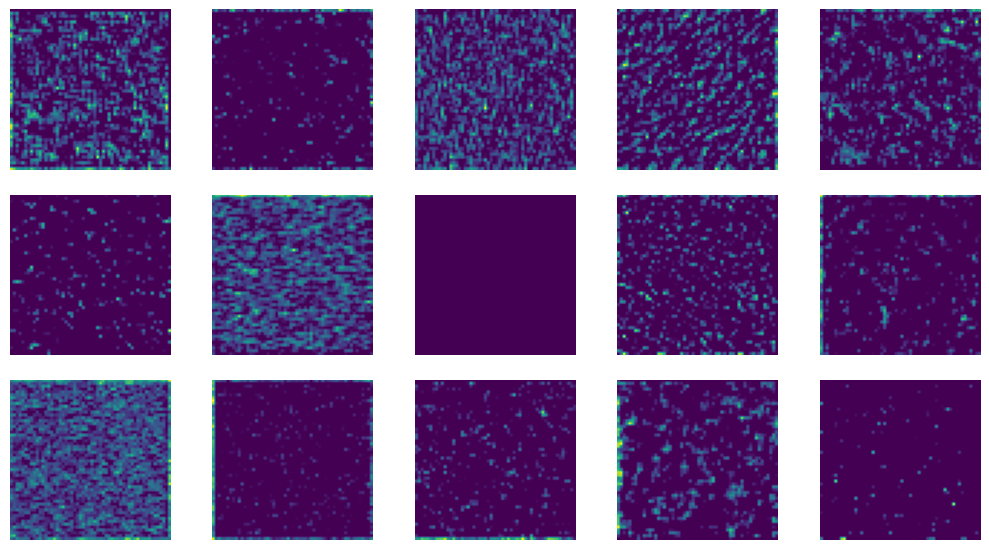

In [41]:
import matplotlib.pyplot as plt

rows, cols = 3, 5

fig = plt.figure(figsize=(10, 6))

for i in range(1, (rows * cols) + 1):
    feature_map = layer_output[i-1, :, :].cpu().numpy()
    fig.add_subplot(rows, cols, i)
    plt.imshow(feature_map, cmap='viridis')
    plt.tight_layout()
    plt.axis(False)

#### Image

In [1]:
import torchvision.transforms as transforms

def viz_plain(layer_num, img, model, device):
    
    # transforms
    transforms_imagenet = transforms.Compose([transforms.Resize(256),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                                   std=(0.229, 0.224, 0.225))])
    img = transforms_imagenet(img).unsqueeze_(dim=0)

    # device-agnostic
    model = model.to(device)
    img = img.to(device)
    
    # Hook function
    feature_maps = []
    def hook_fn(module, input, output):
        feature_maps.append(output)
    
    layer = model_vgg16.features[layer_num]
    handle = layer.register_forward_hook(hook_fn)
    
    # Forward pass the image through the model
    model.eval()
    with torch.inference_mode():
        preds = model(img)
    
    # Print the predicted class
    pred_cls_idx = preds.argmax(dim=1)
    classes_imgnet_txt = "./imagenetv1.txt"
    with open(classes_imgnet_txt, 'r') as f:
        classes_imgnet = f.readlines()
    pred_cls = classes_imgnet[pred_cls_idx]
    print(pred_cls)
    
    # Plot the feature maps
    layer_output = feature_maps[0].squeeze()
    rows, cols = 4, 6
    fig = plt.figure(figsize=(12, 8))
    for i in range(1, (rows * cols) + 1):
        feature_map = layer_output[i-1, :, :].cpu().numpy()
        fig.add_subplot(rows, cols, i)
        plt.imshow(feature_map, cmap='viridis')
        # plt.tight_layout()
        plt.axis(False)

sports car, sport car



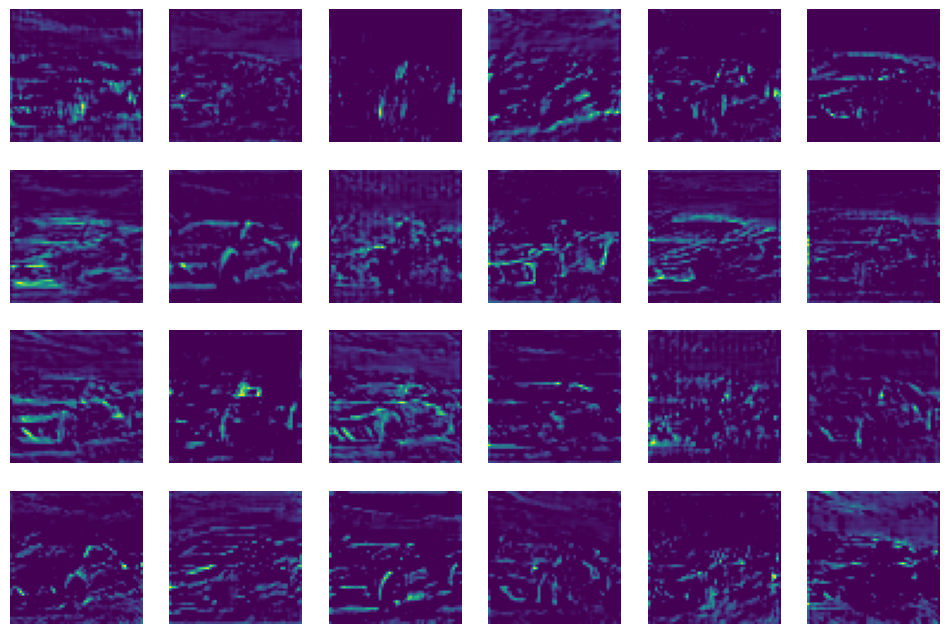

In [34]:
import PIL.Image as Image
img_car = Image.open("./car_01.jpeg")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

viz_plain(10, img_car, model_vgg16, device) 

## Feature visualization using Gradient Ascent

### Layer & feature map selection

In [43]:
layer_num = 28
feature_map_idx = 33

layer = model_vgg16.features[layer_num]
layer

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

### Input noise

In [44]:
input_noise = torch.randn(1, 3, 224, 224, requires_grad=True, device=device)
# input_noise_temp = torch.randn(1, 3, 224, 224) * 20
# input_noise = input_noise_temp.clone().detach().requires_grad_(True).to(device)

### Hook setup

In [45]:
# Hook function
def hook_fn(module, input, output):
    global feature_maps
    feature_maps = output

In [46]:
# Register the hook
handle = layer.register_forward_hook(hook_fn)

In [47]:
model_vgg16.eval()
preds = model_vgg16(input_noise)

In [48]:
feature_maps = feature_maps.squeeze_().requires_grad_().to(device)
feature_maps.shape

torch.Size([512, 14, 14])

### Gradient ascent

In [54]:
steps = 50
lr = .1
optimizer = torch.optim.Adam([input_noise], lr=lr)

In [50]:
for i in range(steps):
    optimizer.zero_grad()
    
    model_vgg16(input_noise)
    # print(feature_maps.shape)
    
    loss = -feature_maps[:,feature_map_idx,:,:].mean()
    loss.backward()
    
    optimizer.step()

In [51]:
input_noise.shape

torch.Size([1, 3, 224, 224])

In [52]:
input_noise_display = input_noise.detach().to('cpu').squeeze().permute(1, 2, 0)
input_noise_display = torch.clamp(input_noise_display, 0, 1)
input_noise_display.shape

torch.Size([224, 224, 3])

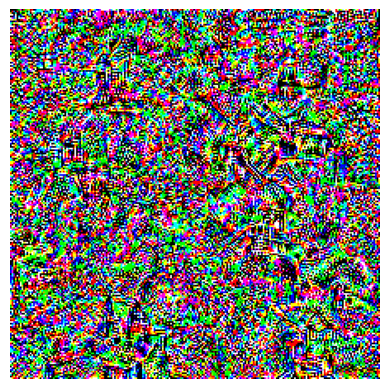

In [53]:
import matplotlib.pyplot as plt

plt.imshow(input_noise_display)
plt.axis('off')
plt.show()


### Generalized function

In [4]:
class Viz_GA():
    def __init__(self, model, feature_map_idx, layer_idx, device, steps, lr):
        self.model = model
        self.feature_map_idx = feature_map_idx
        self.layer_idx = layer_idx
        self.device = device
        self.steps = steps
        self.lr = lr
        self.activations = []
        
    def hook_fn(self, module, input, output):
        self.activations.append(output)
        
    def gradient_ascent(self):
        # input noise
        input_noise = torch.randn(1, 3, 224, 224, requires_grad=True, device=self.device)
        
        # self.model = self.model.to(self.device)
        self.model.eval()
        
        # activate the hook
        layer = self.model.features[self.layer_idx]
        handle = layer.register_forward_hook(self.hook_fn)
        
        # optimizer
        optimizer = torch.optim.Adam([input_noise], lr=self.lr)
        
        # perform gradient ascent
        for i in range(self.steps):
            optimizer.zero_grad()
            
            self.model(input_noise)
            
            loss = -self.activations[0][:, self.feature_map_idx, :, :].mean()
            loss.backward(retain_graph=True)
            optimizer.step()
        
        handle.remove()
        return input_noise
    
    def plot(self):
        input_noise = self.gradient_ascent()
        input_noise_display = input_noise.detach().to('cpu').squeeze().permute(1, 2, 0)
        input_noise_display = torch.clamp(input_noise_display, 0, 1)
        return input_noise_display


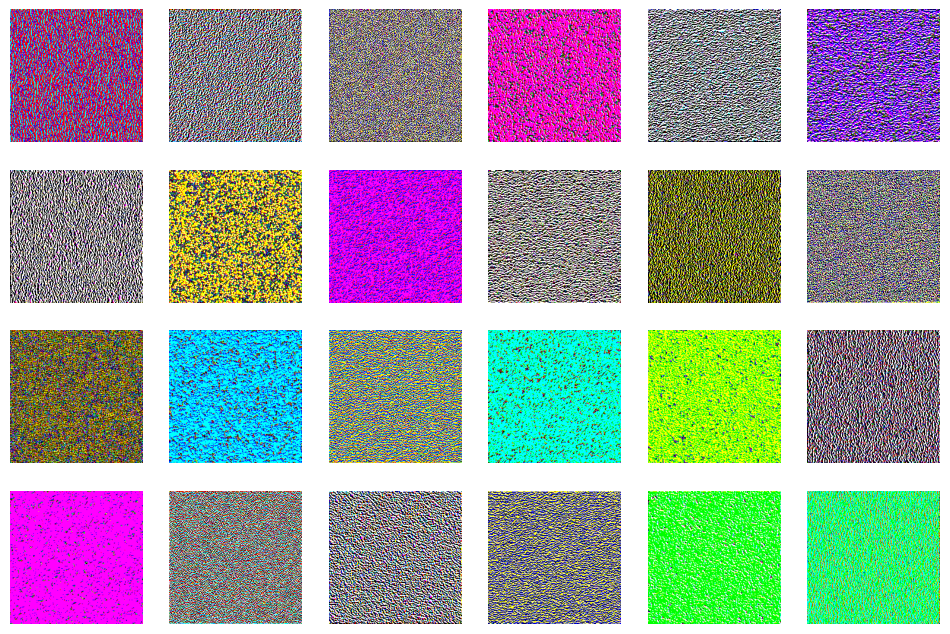

In [5]:
import matplotlib.pyplot as plt
rows, cols = 4, 6

layer_idx = 0

fig = plt.figure(figsize=(12, 8))

for i in range(rows * cols):
    viz_ga = Viz_GA(model_vgg16, i, layer_idx, device, 100, 0.1)
    ax = fig.add_subplot(rows, cols, i+1)
    input_noise_display = viz_ga.plot()
    ax.imshow(input_noise_display)
    ax.axis('off')
    
plt.show()